In [768]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [769]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [770]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [771]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [772]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [773]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size=.75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [774]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [775]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [776]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     58
Name: binding, dtype: int64
0    217
1     20
Name: binding, dtype: int64


In [777]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)
x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [778]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(x_test_sampled, columns  =["sequence"])
final_test_set['binding'] = y_test_sampled
print(final_test_set.binding.value_counts())

1    505
0    505
Name: binding, dtype: int64
1    217
0    217
Name: binding, dtype: int64


In [779]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding, 0.25, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [780]:
print(training_split.shape)
print(test_split.shape)

(1010, 19997)
(434, 19997)


In [781]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
print(train_result.shape)
print(test_result.shape)

(1010,)
(434,)


In [782]:
test_result.sum()

217

In [783]:
train_result.sum()

505

In [791]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    # tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.05)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [792]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=METRICS)

In [793]:
num_epochs = 10
history = model.fit(training_split, train_result, epochs=num_epochs, validation_data=(test_split, test_result))

Epoch 1/10


/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-06 20:46:10.382033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 5.3383 - tp: 453.0000 - fp: 224.0000 - tn: 281.0000 - fn: 52.0000 - accuracy: 0.7267 - precision: 0.6691 - recall: 0.8970 - auc: 0.8709 - prc: 0.9014

2022-10-06 20:46:13.459752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 5s 119ms/step - loss: 5.3383 - tp: 453.0000 - fp: 224.0000 - tn: 281.0000 - fn: 52.0000 - accuracy: 0.7267 - precision: 0.6691 - recall: 0.8970 - auc: 0.8709 - prc: 0.9014 - val_loss: 1.6083 - val_tp: 217.0000 - val_fp: 97.0000 - val_tn: 120.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7765 - val_precision: 0.6911 - val_recall: 1.0000 - val_auc: 0.9493 - val_prc: 0.9432
Epoch 2/10
32/32 [==============================] - 1s 27ms/step - loss: 1.1679 - tp: 461.0000 - fp: 64.0000 - tn: 441.0000 - fn: 44.0000 - accuracy: 0.8931 - precision: 0.8781 - recall: 0.9129 - auc: 0.9464 - prc: 0.9502 - val_loss: 0.9943 - val_tp: 172.0000 - val_fp: 10.0000 - val_tn: 207.0000 - val_fn: 45.0000 - val_accuracy: 0.8733 - val_precision: 0.9451 - val_recall: 0.7926 - val_auc: 0.9234 - val_prc: 0.9351
Epoch 3/10
32/32 [==============================] - 1s 20ms/step - loss: 0.9474 - tp: 419.0000 - fp: 26.0000 - tn: 479.0000 - fn: 86.0000 - accuracy: 0.8891 - precision

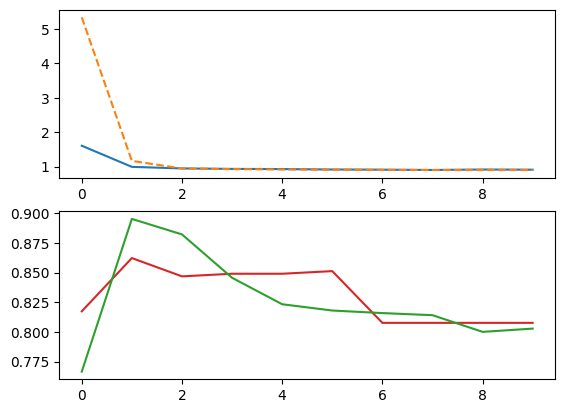

In [794]:
fig, (ax1,ax2) = plt.subplots(2,1)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)

ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')

ax2.plot(history.epoch, k, 'tab:red')
ax2.plot(history.epoch, j, 'tab:green')

# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')

In [795]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [796]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()

In [797]:
unlabeled_test_sequence.shape

(350, 19997)

In [798]:
y = model.predict(unlabeled_test_sequence)

 2/11 [====>.........................] - ETA: 0s

2022-10-06 20:47:46.553732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 13ms/step


In [799]:
y

array([[0.50297004],
       [0.42067304],
       [0.42443714],
       [0.4221262 ],
       [0.42418137],
       [0.42278776],
       [0.42335525],
       [0.42671728],
       [0.42778754],
       [0.5187776 ],
       [0.42260182],
       [0.4259282 ],
       [0.42260867],
       [0.4284702 ],
       [0.42278197],
       [0.42538434],
       [0.421154  ],
       [0.43679875],
       [0.42307836],
       [0.42289662],
       [0.4215421 ],
       [0.42419   ],
       [0.41933984],
       [0.42126197],
       [0.45684728],
       [0.8063652 ],
       [0.42340192],
       [0.42515984],
       [0.42416775],
       [0.42683688],
       [0.425033  ],
       [0.4237192 ],
       [0.4234214 ],
       [0.4219189 ],
       [0.42444393],
       [0.42426446],
       [0.42301592],
       [0.42357552],
       [0.4288711 ],
       [0.42230356],
       [0.4230729 ],
       [0.4221097 ],
       [0.42389864],
       [0.42055178],
       [0.41874576],
       [0.42292622],
       [0.42428464],
       [0.423

In [800]:
# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [801]:
z[61]

1

In [802]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()

In [ ]:
ls